制作者 Takeda Shun

所属 東京都市大学知識工学部情報科学科 4年


#目的

1. Colabでのpytorchの使い方の学習
2. 音源分離の体験
3. Colab上での音の再生


#音源分離
- 歌声分離(sining voice separation)

  歌声分離タスクは、録音から歌手の声を分離する

https://ejhumphrey.com/assets/pdf/jansson2017singing.pdf

- 今回作るモデル

モデルを図で表したときにU型に見えることからU-Netと言われている

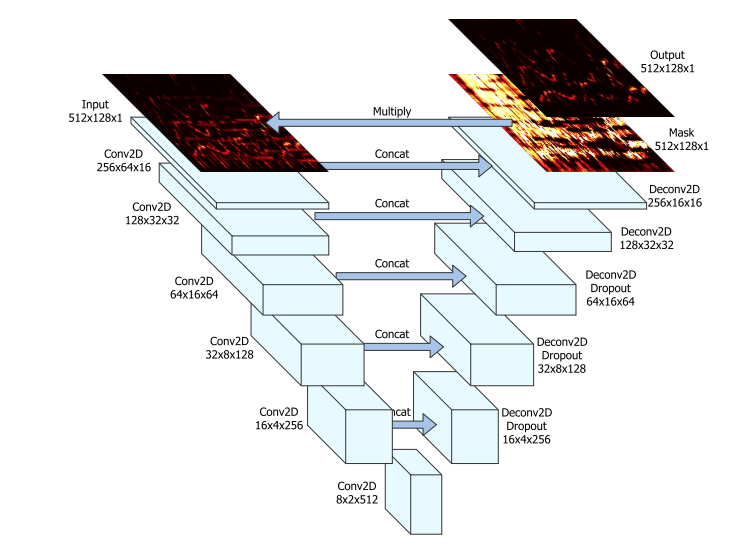

##このnotebookの流れ
 
 

1.   dataloader作成
2.   model定義
3.   学習
4.   音源分離実験



In [ ]:
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import h5py

Falseのときはランタイムの設定を確認

In [ ]:
print(torch.cuda.is_available())  # GPUが使える：True、使えない：False

True


#dataloader

学習のときデータの供給のための処理を行う

In [ ]:
#hdf5データ(スペクトログラム)のロード
path = '/content/drive/Shared drives/IPL Freedom/Dataset/musdb18hq_spectorogram/mix_vocals_spec_1024_256.hdf5'
split = 7856 #データの全長11223(train:約7割,valid:約3割)
with h5py.File(path,'r') as f:
  #trainingデータ(訓練用)とvalidationデータ(精度検証用)に分割する
  mixture_train = f['mixture'][:split,0:512,:]
  vocals_train  = f['vocals'][:split,0:512,:]
  mixture_valid = f['mixture'][split:,0:512,:]
  vocals_valid  = f['vocals'][split:,0:512,:]

In [ ]:
mixture_train = mixture_train[:,np.newaxis]
vocals_train  = vocals_train[:,np.newaxis]
mixture_valid = mixture_valid[:,np.newaxis]
vocals_valid  = vocals_valid[:,np.newaxis]

In [ ]:
# データ関連のユーティリティクラスをインポート
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 16 #ミニバッチのサイズ

# NumPy多次元配列からテンソルに変換し、データ型はfloatに変換する
mixture_train = torch.from_numpy(mixture_train).float()
vocals_train  = torch.from_numpy(vocals_train).float()
mixture_valid = torch.from_numpy(mixture_valid).float()
vocals_valid  = torch.from_numpy(vocals_valid).float()



In [ ]:
# 「データ（X）」と「教師ラベル（y）」を、1つの「データセット（dataset）」にまとめる
dataset_train = TensorDataset(mixture_train, vocals_train)  # 訓練用
dataset_valid = TensorDataset(mixture_valid, vocals_valid)  # 精度検証用

In [ ]:
# ミニバッチを扱うための「データローダー（loader）」（訓練用と精度検証用）を作成
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE)

#モデルの定義

学習するモデルのネットワークを記述する

In [ ]:
#活性化関数(activation function)の定義
acti_enc = torch.nn.LeakyReLU(0.2)
acti_dec = torch.nn.ReLU()
acti_out = torch.nn.Sigmoid()

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    #1 -> 16
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn1 = nn.BatchNorm2d(16)
    #16 -> 32
    self.conv2   = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn2     = nn.BatchNorm2d(32)
    #32 -> 64
    self.conv3   = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn3     = nn.BatchNorm2d(64)
    #64 -> 128
    self.conv4   = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn4     = nn.BatchNorm2d(128)
    #128 -> 256
    self.conv5   = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn5     = nn.BatchNorm2d(256)
    #256 -> 512
    self.conv6   = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn6     = nn.BatchNorm2d(512)

    #512 -> 256
    self.up1     = nn.ConvTranspose2d(512,256,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn7     = nn.BatchNorm2d(256)
    self.dout1   = nn.Dropout(p=0.5)

    #256+256 -> 128
    self.up2     = nn.ConvTranspose2d(512,128,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn8     = nn.BatchNorm2d(128)
    self.dout2   = nn.Dropout(p=0.5)
    #128+128 -> 64
    self.up3     = nn.ConvTranspose2d(256,64,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn9     = nn.BatchNorm2d(64)
    self.dout3   = nn.Dropout(p=0.5)
    #64+64 -> 32
    self.up4     = nn.ConvTranspose2d(128,32,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn10    = nn.BatchNorm2d(32)

    #32+32 -> 16
    self.up5     = nn.ConvTranspose2d(64,16,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    self.bn11    = nn.BatchNorm2d(16)
    #16+16 -> 1
    
    self.up6    = nn.ConvTranspose2d(32,1,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    
    
  def forward(self,x):
    #encoder
    layer1  = acti_enc(self.bn1(self.conv1(x)))
    layer2  = acti_enc(self.bn2(self.conv2(layer1)))
    layer3  = acti_enc(self.bn3(self.conv3(layer2)))
    layer4  = acti_enc(self.bn4(self.conv4(layer3)))
    layer5  = acti_enc(self.bn5(self.conv5(layer4)))
    layer6  = acti_enc(self.bn6(self.conv6(layer5)))
    
    #decoder
    dlayer1 = acti_dec(self.dout1(self.bn7(self.up1(layer6))))
    dlayer2 = acti_dec(self.dout2(self.bn8(self.up2(torch.cat([dlayer1,layer5],dim=1)))))
    dlayer3 = acti_dec(self.dout3(self.bn9(self.up3(torch.cat([dlayer2,layer4],dim=1)))))
    dlayer4 = acti_dec(self.bn10(self.up4(torch.cat([dlayer3,layer3],dim=1))))
    dlayer5 = acti_dec(self.bn11(self.up5(torch.cat([dlayer4,layer2],dim=1))))
    Mask = acti_out(self.up6(torch.cat([dlayer5,layer1],dim=1)))
    output  = torch.multiply(Mask,x)
    return output 

In [ ]:
#modelのインスタンス化
model = UNet()

#学習／最適化（オプティマイザ）



##簡単な流れ

1. 入力 
2. 出力
3. 教師データとの誤差計算
4. 逆伝播
5. 1に戻る

決められた条件を満たすまでループする(epochs,validation loss, etc...)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(),
                       lr=0.001,
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=0, 
                       amsgrad=False)

criterion = nn.L1Loss()            # 基準＝損失関数

In [ ]:
#GPUを使うための設定
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dev)
model = model.to(dev)

cuda:0


In [ ]:
def train_step(train_X, train_y):
    # 訓練モードに設定
    model.train()

    # フォワードプロパゲーションで出力結果を取得
    #train_X                # 入力データ
    pred_y = model(train_X) # 出力結果
    #train_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算し、勾配を求める
    optimizer.zero_grad()   # 勾配を0で初期化（※累積してしまうため要注意）
    loss = criterion(pred_y, train_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得、数個前のセルで宣言
    loss.backward()   # 逆伝播の処理として勾配を計算（自動微分）

    # 勾配を使ってパラメーター（重みとバイアス）を更新
    optimizer.step()  # 指定されたデータ分の最適化を実施

    return loss.item()  # ※item()=Pythonの数値

def valid_step(valid_X, valid_y):
    # 評価モードに設定（※dropoutなどの挙動が評価用になる）
    model.eval()
    
    # フォワードプロパゲーションで出力結果を取得
    #valid_X                # 入力データ
    pred_y = model(valid_X) # 出力結果
    #valid_y                # 正解ラベル

    # 出力結果と正解ラベルから損失を計算
    loss = criterion(pred_y, valid_y)     # 誤差（出力結果と正解ラベルの差）から損失を取得
    # ※評価時は勾配を計算しない
  
    # 損失を返す
    return loss.item()

In [ ]:
#GPUの状態確認
!nvidia-smi

Sun Nov 22 09:11:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |    993MiB / 15079MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# パラメーター（重みやバイアス）の初期化を行う関数の定義
def init_parameters(layer):
    if type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d :
        nn.init.xavier_uniform_(layer.weight) # 重みを「一様分布のランダム値」に初期化
        layer.bias.data.fill_(0.0)            # バイアスを「0」に初期化

# 学習の前にパラメーター（重みやバイアス）を初期化する
model.apply(init_parameters)

# 定数（学習／評価時に必要となるもの）
EPOCHS = 100             # エポック数： 100

# 変数（学習／評価時に必要となるもの）
avg_loss = 0.0           # 「訓練」用の平均「損失値」
avg_val_loss = 0.0       # 「評価」用の平均「損失値」


# 損失の履歴を保存するための変数
train_history = []
valid_history = []

for epoch in range(EPOCHS):
    # forループ内で使う変数と、エポックごとの値リセット
    total_loss = 0.0     # 「訓練」時における累計「損失値」
    total_val_loss = 0.0 # 「評価」時における累計「損失値」
    total_train = 0      # 「訓練」時における累計「データ数」
    total_valid = 0      # 「評価」時における累計「データ数」

    for train_X, train_y in loader_train:
        # 【重要】1ミニバッチ分の「訓練」を実行
        train_X,train_y = train_X.to(dev),train_y.to(dev)
        loss = train_step(train_X, train_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_loss += loss          # 訓練用の累計損失値
        total_train += len(train_y) # 訓練データの累計数
            
    for valid_X, valid_y in loader_valid:
        valid_X, valid_y = valid_X.to(dev), valid_y.to(dev)
        # 【重要】1ミニバッチ分の「評価（精度検証）」を実行
        val_loss = valid_step(valid_X, valid_y)

        # 取得した損失値と正解率を累計値側に足していく
        total_val_loss += val_loss  # 評価用の累計損失値
        total_valid += len(valid_y) # 訓練データの累計数

    # ミニバッチ単位で累計してきた損失値や正解率の平均を取る
    n = epoch + 1                             # 処理済みのエポック数
    avg_loss = total_loss / n                 # 訓練用の平均損失値
    avg_val_loss = total_val_loss / n         # 評価用の平均損失値
    

    # グラフ描画のために損失の履歴を保存する
    train_history.append(avg_loss)
    valid_history.append(avg_val_loss)

    # 損失や正解率などの情報を表示
    print(f'[Epoch {epoch+1:3d}/{EPOCHS:3d}]' , f' loss: {avg_loss:.5f}', f' val_loss: {avg_val_loss:.5f}')

print('Finished Training')


[Epoch   1/100]  loss: 0.56002  val_loss: 0.38934
[Epoch   2/100]  loss: 0.22386  val_loss: 0.12329
[Epoch   3/100]  loss: 0.13919  val_loss: 0.13030
[Epoch   4/100]  loss: 0.09934  val_loss: 0.05817
[Epoch   5/100]  loss: 0.07652  val_loss: 0.06161
[Epoch   6/100]  loss: 0.06177  val_loss: 0.03401
[Epoch   7/100]  loss: 0.05097  val_loss: 0.03071
[Epoch   8/100]  loss: 0.04376  val_loss: 0.02677
[Epoch   9/100]  loss: 0.03771  val_loss: 0.02195
[Epoch  10/100]  loss: 0.03305  val_loss: 0.02268
[Epoch  11/100]  loss: 0.02960  val_loss: 0.01817
[Epoch  12/100]  loss: 0.02661  val_loss: 0.01566
[Epoch  13/100]  loss: 0.02417  val_loss: 0.01741
[Epoch  14/100]  loss: 0.02214  val_loss: 0.01436
[Epoch  15/100]  loss: 0.02033  val_loss: 0.01776
[Epoch  16/100]  loss: 0.01892  val_loss: 0.01204
[Epoch  17/100]  loss: 0.01753  val_loss: 0.01098
[Epoch  18/100]  loss: 0.01627  val_loss: 0.01234
[Epoch  19/100]  loss: 0.01533  val_loss: 0.01021
[Epoch  20/100]  loss: 0.01446  val_loss: 0.00935


In [ ]:
#学習済みモデルの保存(やらなくてもあとのコードは動く)
model_path = '/content/drive/MyDrive/UNet_pth/model_UNet.pth'
torch.save(model.state_dict(), model_path)


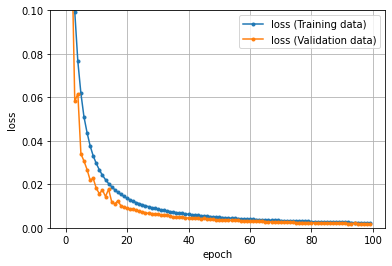

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# 学習結果（損失）のグラフを描画
epochs = len(train_history)
plt.plot(range(epochs), train_history, marker='.', label='loss (Training data)')
plt.plot(range(epochs), valid_history, marker='.', label='loss (Validation data)')
plt.legend(loc='best')
plt.grid()
plt.ylim(0,0.1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

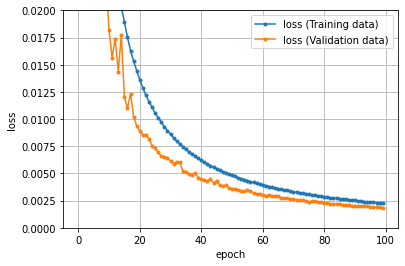

In [ ]:
epochs = len(train_history)
plt.plot(range(epochs), train_history, marker='.', label='loss (Training data)')
plt.plot(range(epochs), valid_history, marker='.', label='loss (Validation data)')
plt.legend(loc='best')
plt.grid()
plt.ylim(0,0.02)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
#メモリ節約のためにtraining dataのメモリ開放する
import gc
del mixture_train
del vocals_train 
del mixture_valid
del vocals_valid 
del dataset_train
del dataset_valid
del loader_train
del loader_valid
gc.collect()

2853

#分離テスト

In [ ]:
#学習済みモデルを用いるときに実行するセル
#パラメータのload
"""
学習したモデルを上書きしてしまうので注意

model_path = "/content/drive/MyDrive/UNet_pth/model.pth"
model.load_state_dict(torch.load(model_path))
"""

<All keys matched successfully>

In [ ]:
import librosa
from librosa.core import stft,istft
import termcolor


In [ ]:
def load_mag(file,sr=16000,n_fft=1024,win_l=1024,hop_l=256,split_size=128):
    print("load_mag",end=" ")
    y, sr = librosa.load(file,sr=sr,mono=True)
    spec = librosa.stft(y,n_fft=n_fft,win_length=win_l,hop_length=hop_l)
    #振幅に変換
    mag = np.abs(spec)
    #最大値正規化
    mag /= np.max(mag)
    phase = np.exp(1.j*np.angle(spec))
    #サイズをinput_sizeの倍数に合わせる
    if mag.shape[1] % split_size == 0:
        seq_number = int(mag.shape[1] / split_size)
    else:
        seq_number = int(mag.shape[1] / split_size) + 1
        pad_value = split_size - mag.shape[1] % split_size
        mag = np.pad(mag,((0,0),(0,pad_value)),mode='constant',constant_values=0.0)
        phase = np.pad(phase,((0,0),(0,pad_value)),mode='constant',constant_values=0.0)
    split_mag = []
    split_phase = []
    for frame in range(seq_number):
        tmp_mag = mag[:,frame*split_size : frame*split_size+split_size]
        tmp_phase = phase[:,frame*split_size : frame*split_size+split_size]
        split_mag.append(tmp_mag)
        split_phase.append(tmp_phase)
        #print('process number {0} / {1}'.format(frame,seq_number))
    split_mag = np.array(split_mag)
    split_phase = np.array(split_phase)  
    print("Completed load_mag")
    return split_mag,split_phase

In [ ]:
def compute_audio(input_mag,model):
    input_mag = torch.from_numpy(input_mag).float()
    input_mag = input_mag.to(dev)
    audio = model(input_mag)
    audio = audio.to('cpu').detach().numpy()
    return audio

In [ ]:
def compute_separation(split_mag,split_phase,split_size,hop_l,win_l,model):
    all_mag = []
    for i in range(split_mag.shape[0]):
        input_spec = split_mag[i:i+1,0:512]
        input_spec = input_spec[:,np.newaxis]
        mag_sp = compute_audio(input_spec,model)        
        
        all_mag.append(mag_sp)
    

    all_mag = np.array(all_mag)
    #楽器復元のための前処理
    
    vocals = np.empty(0)
    index = 0
    for audio in all_mag: 
        audio = np.reshape(audio,[1,512,128])
        mag   = np.reshape(split_mag[index,0:512],[512,128]) 
        phase = np.reshape(split_phase[index,0:512],[1,512,128])
        
        #bin数合わせに0^padding
        
        pad_bin = np.zeros([1,1,split_mag.shape[2]],dtype="float32")
        comp_v = np.concatenate([phase * audio,pad_bin],1)

        #断片をarrayに追加
        
        if index == 0:
            vocals = comp_v
            index+=1
            continue
        
        index+=1
        vocals = np.concatenate([vocals,comp_v],2)

    print(" vocals shape:",vocals.shape,end="")
    
    vocals = np.reshape(vocals,[len(vocals[0]),len(vocals[0][0])])
    vocals_wav = istft(vocals,hop_length=hop_l,win_length=win_l)

    print(" Completed istft, return narray()")
    
    return vocals_wav

※音源のパスを設定

In [ ]:
test_pathlist =["/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Enda Reilly - Cur An Long Ag Seol/mixture.wav",
                "/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Angels In Amplifiers - I'm Alright/mixture.wav",
                "/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/AM Contra - Heart Peripheral/mixture.wav",
                "/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Cristina Vane - So Easy/mixture.wav"]

In [ ]:
sep_vocals = []
split_size = 128
hop_l = 256
win_l = 1024
for path in test_pathlist:
  print(path,end="\t")
  split_mag,split_phase = load_mag(path)
  result = compute_separation(split_mag=split_mag,
                              split_phase=split_phase,
                              split_size=split_size,
                              hop_l=hop_l,
                              win_l=win_l,
                              model=model)
  sep_vocals.append(result)

print(termcolor.colored('\nEnd of Separation', 'green'))

/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Enda Reilly - Cur An Long Ag Seol/mixture.wav	load_mag Completed load_mag
 vocals shape: (1, 513, 11776) Completed istft, return narray()
/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Angels In Amplifiers - I'm Alright/mixture.wav	load_mag Completed load_mag
 vocals shape: (1, 513, 11264) Completed istft, return narray()
/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/AM Contra - Heart Peripheral/mixture.wav	load_mag Completed load_mag
 vocals shape: (1, 513, 13184) Completed istft, return narray()
/content/drive/MyDrive/U-Net/U-Net-multi/data/musdb18hq/test/Cristina Vane - So Easy/mixture.wav	load_mag Completed load_mag
 vocals shape: (1, 513, 16000) Completed istft, return narray()

End of Separation


In [ ]:
sep_vocals[0].shape

(3014400,)

#音の再生
※実際にセルを実行するまえにpathに音源があるか確認




In [ ]:
import IPython.display as ipd
import os
sr = 16000 #sample rate
name = []
#曲名の取得
for path in test_pathlist:
  name.append(os.path.basename(os.path.dirname(path)))

例)100epoch訓練したモデルによる分離音源

###1曲目

In [ ]:
#元音源
y0, _ = librosa.load(test_pathlist[0],sr=sr,mono=True)
print(name[0],"::mixture","\n")
ipd.Audio(y0, rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#例)17秒あたりから歌いはじめ
print(name[0],"\n")
ipd.Audio(sep_vocals[0], rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

###2曲目

In [ ]:
#元音源
y1, _ = librosa.load(test_pathlist[1],sr=sr,mono=True)
print(name[1],"::mixture","\n")
ipd.Audio(y1, rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#例)17秒あたりから歌いはじめ
print(name[1],"\n")
ipd.Audio(sep_vocals[1], rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

###３曲目

In [ ]:
#元音源
y2, _ = librosa.load(test_pathlist[2],sr=sr,mono=True)
print(name[2],"::mixture","\n")
ipd.Audio(y2, rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#例)
print(name[2],"\n")
ipd.Audio(sep_vocals[2], rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

###４曲目

In [ ]:
#元音源,30秒あたりから歌いはじめ
y3, _ = librosa.load(test_pathlist[3],sr=sr,mono=True)
print(name[3],"::mixture","\n")
ipd.Audio(y3, rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#例)
print(name[3],"\n")
ipd.Audio(sep_vocals[3], rate=sr) 

Output hidden; open in https://colab.research.google.com to view.

機能
- cat()
  
  指定した軸で出力を連結します。連結後はTensorの形状が変化するので注意

- BatchNorm2d

  各バッチ毎に前の層の出力（このレイヤーへの入力）を正規化します． つまり，平均を0，標準偏差値を1に近づける変換を適用します．

- Dropout

  ニューラルネットワークを学習する際に、ある更新で層の中のノードのうちのいくつかを無効にして（そもそも存在しないかのように扱って）学習を行い、次の更新では別のノードを無効にして学習を行うことを繰り返します。これにより学習時にネットワークの自由度を強制的に小さくして汎化性能を上げ、過学習を避けることができます


In [ ]:
#モデル可視化ライブラリ
!pip install torchviz

     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=a49247ca132dba06291d0146099fc0c044689ef009db30cb523b8fa8be600813
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


(1, 1, 512, 128)


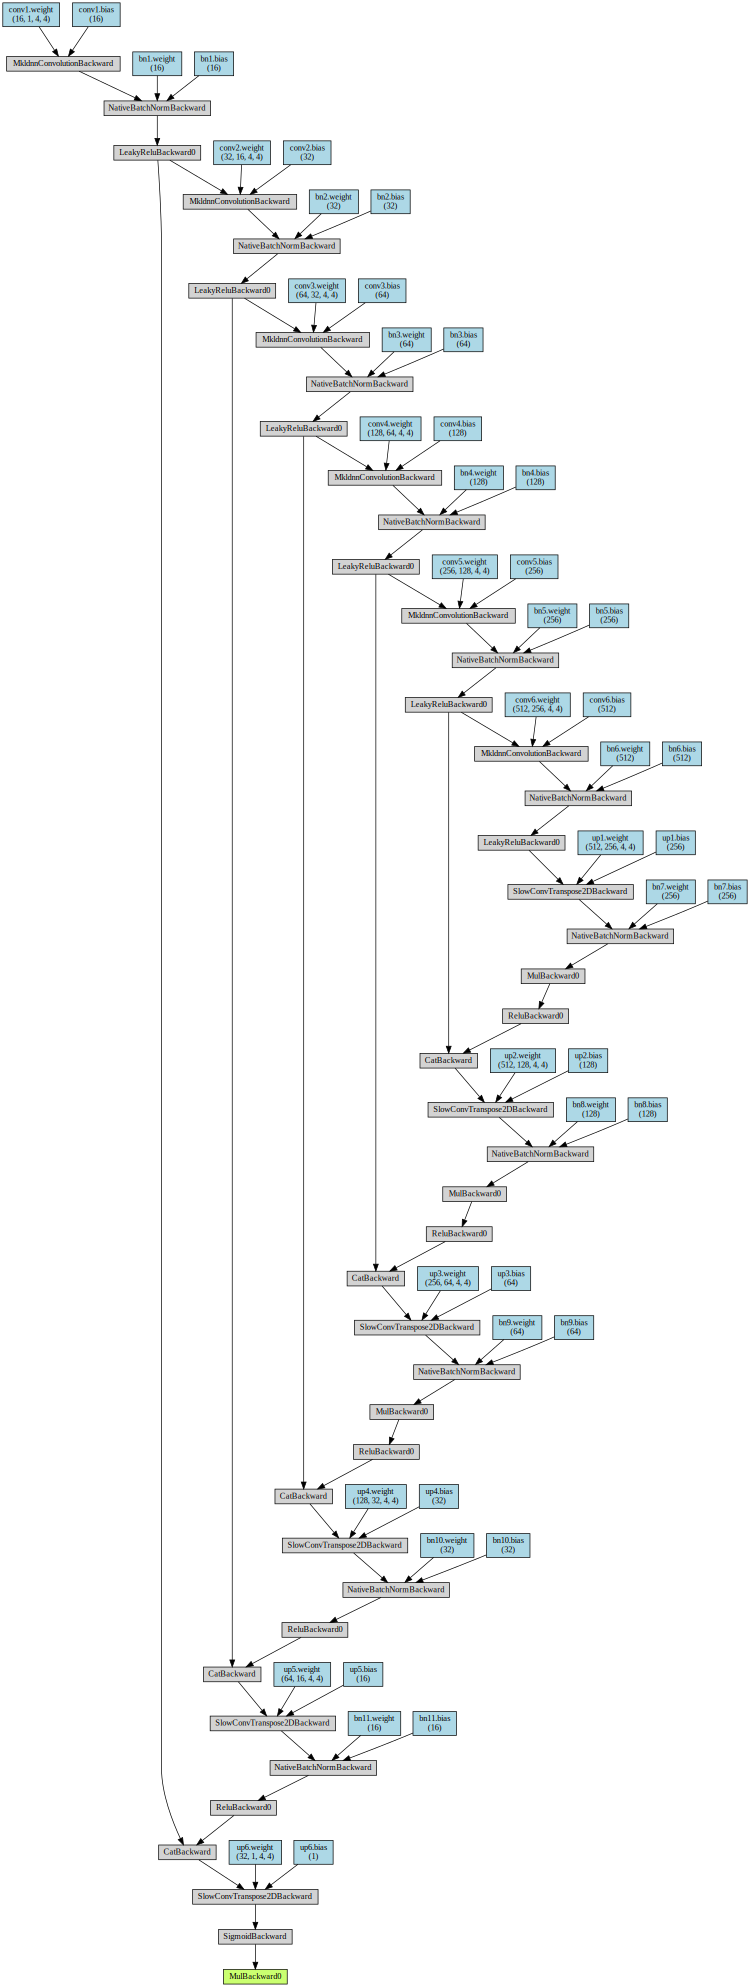

In [ ]:
#可視化
from torchviz import make_dot  # 「torchviz」モジュールから「make_dot」関数をインポート
X_data = np.ones((1,1,512,128), dtype='float32')#テスト用入力データ作成
X_data = torch.from_numpy(X_data)
y_pred = model(X_data)  # このモデルに、データを入力して、出力を得る（＝予測：predict）
make_dot(y_pred, params=dict(model.named_parameters()))